### Import packages to graph results

In [1]:
import pandas as pd
import plotly.graph_objects as go

# Import from shared notebook containing helper methods
import import_ipynb
from shared_notebook import create_dataframe, write_image, create_figure

importing Jupyter notebook from shared_notebook.ipynb
Stored 'colorPallet' (list)


### Set default color palete and size for making plots

In [2]:
%store -r colorPallet

### glob all the log files into a list, then create a dataframe with all json data

In [3]:
log_dir='../logs/openfaas/kops-multi-tenant-spot-1x-8vcpu-16gb/nlp'
preprocess_df = create_dataframe(f'{log_dir}/*preprocess*')
train_df = create_dataframe(f'{log_dir}/*train*')
query_df = create_dataframe(f'{log_dir}/*query*')

# Make bar plots to profile nlp function data

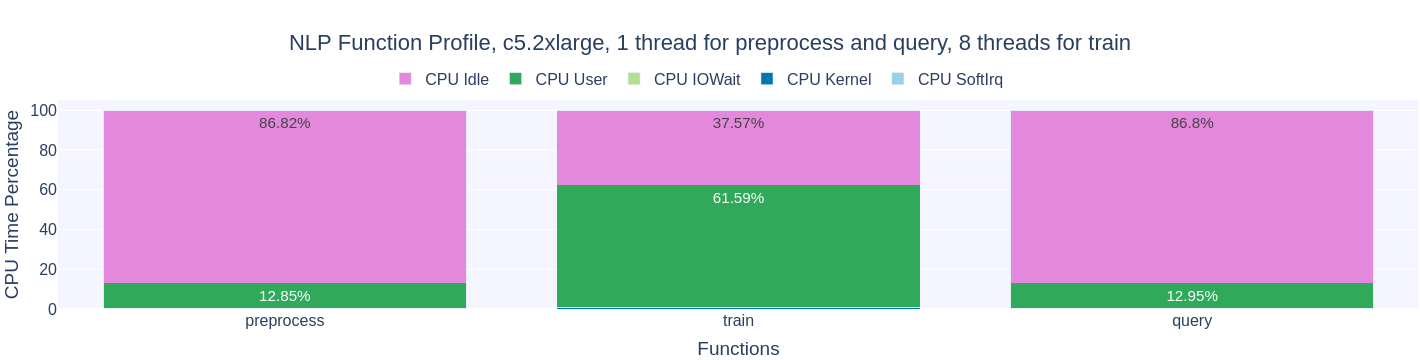

In [6]:
fig = create_figure('NLP Function Profile, c5.2xlarge, 1 thread for preprocess and query, 8 threads for train', 'Functions', 'CPU Time Percentage', make_subplot=True)

fig.update_layout(
    barmode='stack',
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

profileData = pd.DataFrame()
profileData['payload'] = ["preprocess", "train", "query"]
# Metrics for profiling
metrics = ['SoftIrq', 'Kernel', 'IOWait', 'User', 'Idle']
profileData['cpuTotalTime'] = [0, 0, 0]
for metric in metrics:
    preprocessMean = preprocess_df[f'cpu{metric}Delta'].mean()
    trainMean = train_df[f'cpu{metric}Delta'].mean()
    queryMean = query_df[f'cpu{metric}Delta'].mean()
    
    profileData[metric] = [preprocessMean, trainMean, queryMean]
    profileData['cpuTotalTime'] = [
        preprocessMean + profileData['cpuTotalTime'][0],
        trainMean + profileData['cpuTotalTime'][1],
        queryMean + profileData['cpuTotalTime'][2]
    ]

#profileData['runtime'] = [round(normal_df['runtime'].mean() / 1000), round(tumor_df['runtime'].mean() / 1000)]
#profileData['runtimeText'] = [f"Runtime:<br>{value} s" for value in profileData['runtime']]
for i, metric in enumerate(metrics):
    profileData[metric] = [
        profileData[metric][0] * 100 / profileData['cpuTotalTime'][0],
        profileData[metric][1] * 100 / profileData['cpuTotalTime'][1],
        profileData[metric][2] * 100 / profileData['cpuTotalTime'][2]
    ]
    text = [f'{round(val, 2)}%' for val in profileData[metric]]
    fig.add_trace(go.Bar(x = profileData["payload"],
                         y = profileData[metric],
                         name = f"CPU {metric}", marker_color=colorPallet[i],
                         text = text),
                  secondary_y=False)

fig.show()

# Save graph
write_image(fig, 'nlp_profile_bars.png')